In [75]:
import pandas as pd

# Load your dataset
df = pd.read_csv('Data\cleaned_Phishing.csv')

In [16]:
# Assuming 'Result' is your target column
X = df.drop(columns=['Result'])  # Features
y = df['Result']  # Target variable

In [17]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print('Shape of X_train and X_test:', X_train.shape, X_test.shape)
print('Shape of y_train and y_test:', y_train.shape, y_test.shape)

Shape of X_train and X_test: (8844, 36) (2211, 36)
Shape of y_train and y_test: (8844,) (2211,)


In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, 
    y_train, 
    test_size=0.2,  # 20% of the training data will be used for validation
    random_state=42  # For reproducibility
)

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set parameters
INPUT_SHAPE = X_train_scaled.shape[1]
DENSE_LAYERS = [64, 32]
OUTPUT_UNITS = 1
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

# Initialize callbacks
early_stopping = EarlyStopping(
   monitor='val_loss',
   patience=5,
   restore_best_weights=True,
   mode='min'
)

# Add model checkpoint to save best model 
model_checkpoint = ModelCheckpoint(
   'best_model.h5',
   monitor='val_loss', 
   save_best_only=True,
   mode='min'
)

# Build the model with regularization and dropout
model2 = keras.Sequential([
   layers.Input(shape=(INPUT_SHAPE,)),
   
   # Add batch normalization at the start
   layers.BatchNormalization(),
   
   # First dense layer
   layers.Dense(DENSE_LAYERS[0], activation='relu',
               kernel_regularizer=keras.regularizers.l2(0.01)),
   layers.Dropout(0.3),
   layers.BatchNormalization(),
   
   # Second dense layer
   layers.Dense(DENSE_LAYERS[1], activation='relu', 
               kernel_regularizer=keras.regularizers.l2(0.01)),
   layers.Dropout(0.2),
   layers.BatchNormalization(),
   
   # Output layer
   layers.Dense(OUTPUT_UNITS, activation='sigmoid')
])

# Compile with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
   initial_learning_rate,
   decay_steps=1000,
   decay_rate=0.9
)

model2.compile(
   optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
   loss='binary_crossentropy',
   metrics=['accuracy', keras.metrics.AUC()]
)

# Training
history2 = model2.fit(
   X_train_scaled,
   y_train,
   batch_size=BATCH_SIZE, 
   epochs=EPOCHS,
   validation_split=VALIDATION_SPLIT,
   callbacks=[early_stopping, model_checkpoint],
   verbose=1
)

Epoch 1/30
222/222 [==============================] - 2s 4ms/step - loss: 1.0890 - accuracy: 0.8249 - auc: 0.9048 - val_loss: 0.7211 - val_accuracy: 0.9344 - val_auc: 0.9837
Epoch 2/30
 43/222 [====>.........................] - ETA: 0s - loss: 0.7282 - accuracy: 0.9164 - auc: 0.9730

C:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


222/222 [==============================] - 1s 3ms/step - loss: 0.6429 - accuracy: 0.9134 - auc: 0.9706 - val_loss: 0.4778 - val_accuracy: 0.9418 - val_auc: 0.9872
Epoch 3/30
222/222 [==============================] - 1s 3ms/step - loss: 0.4429 - accuracy: 0.9244 - auc: 0.9782 - val_loss: 0.3434 - val_accuracy: 0.9435 - val_auc: 0.9891
Epoch 4/30
222/222 [==============================] - 1s 3ms/step - loss: 0.3439 - accuracy: 0.9249 - auc: 0.9802 - val_loss: 0.2677 - val_accuracy: 0.9508 - val_auc: 0.9898
Epoch 5/30
222/222 [==============================] - 1s 3ms/step - loss: 0.2730 - accuracy: 0.9353 - auc: 0.9843 - val_loss: 0.2288 - val_accuracy: 0.9457 - val_auc: 0.9906
Epoch 6/30
222/222 [==============================] - 1s 3ms/step - loss: 0.2477 - accuracy: 0.9313 - auc: 0.9834 - val_loss: 0.1999 - val_accuracy: 0.9542 - val_auc: 0.9904
Epoch 7/30
222/222 [==============================] - 1s 4ms/step - loss: 0.2204 - accuracy: 0.9391 - auc: 0.9852 - val_loss: 0.1809 - val_ac

In [46]:
print(model2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 36)                144       
 Normalization)                                                  
                                                                 
 dense_15 (Dense)            (None, 64)                2368      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)               

In [49]:
# Get validation accuracy from history
val_accuracy = history2.history['val_accuracy'][-1]  # Last validation accuracy

# Get test accuracy
test_metrics = model2.evaluate(X_test_scaled, y_test, verbose=0)
test_accuracy = test_metrics[1]  # Index 1 contains accuracy (0 is loss, 2 is AUC)

# Print both accuracies
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.9627
Test Accuracy: 0.9593


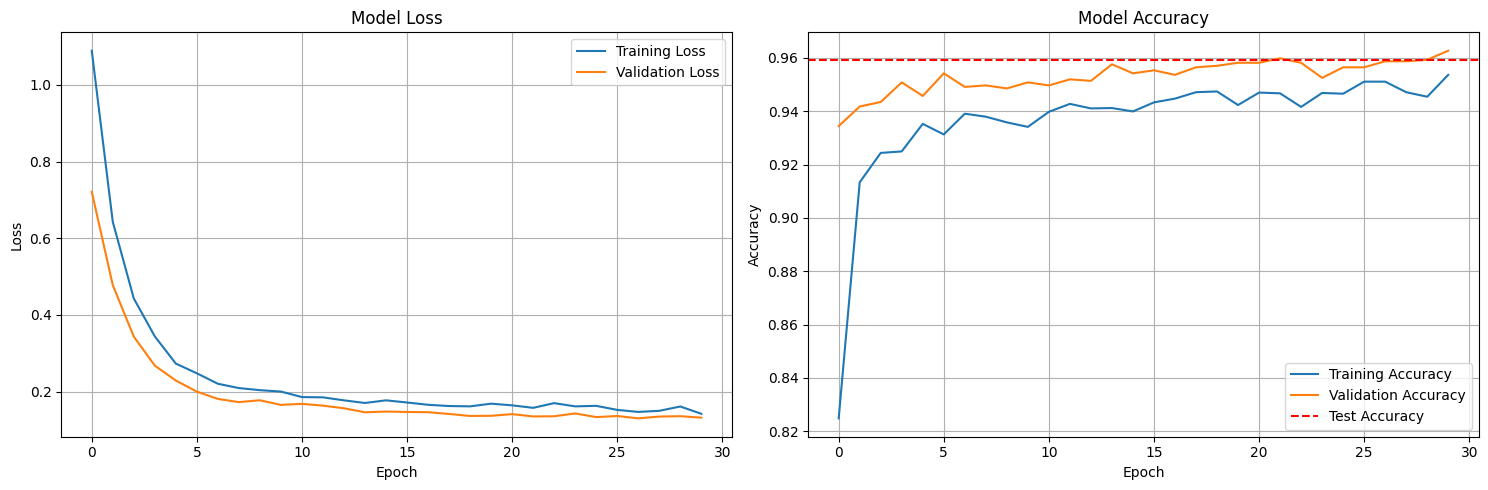

In [52]:
# Create subplots for loss and accuracy
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history2.history['loss'], label='Training Loss')
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(history2.history['accuracy'], label='Training Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax2.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

70/70 [==============================] - 0s 1ms/step


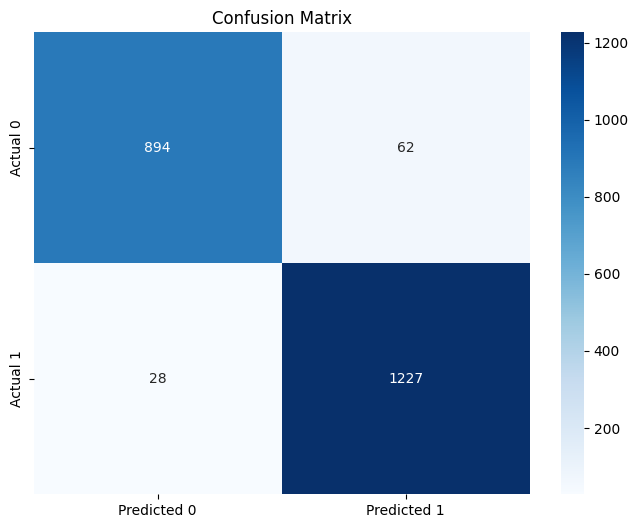


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       956
           1       0.95      0.98      0.96      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



In [53]:
# Confusion Matrix and Classification Report

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import numpy as np

# Get predictions
y_pred_proba = model2.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix with Seaborn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


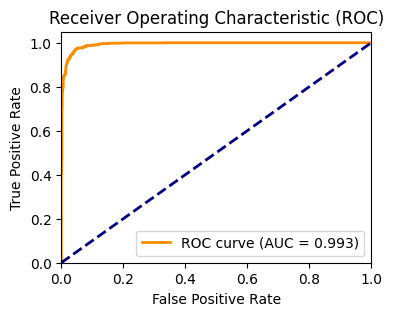

In [56]:
# ROC Curve
plt.figure(figsize=(4, 3))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

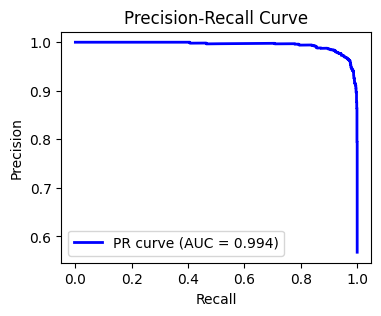

In [57]:
# Precision-Recall Curve
plt.figure(figsize=(4,3))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [58]:
model2.save('PhishingWebsites.h5')

C:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
def representative_dataset():
    for _ in range(100):
      data =  X_test
      yield [data.astype(np.float32)]
        
print(representative_dataset())

<generator object representative_dataset at 0x0000018450D7DA80>


In [62]:
def representative_dataset():
    for _ in range(100):
      data =  X_test
      yield [data.astype(np.float32)]
        
print(representative_dataset())

<generator object representative_dataset at 0x0000018450CDFCA0>


In [63]:
# Converting a tf.Keras model to a TensorFlow Lite model.
# It is preferred to use TFLiteConverter from saved model and then
# Also provide representative dataset to train the converted TFLite model
# Avoid calling the TFLite converter directly from model
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

tf.saved_model.save(model2, "saved_website_seq_model_keras_dir")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_website_seq_model_keras_dir")

# Though its size is not much, optimizer is used here to check whether it works on ESP32
# if this is chosen, tf.lite.Optimize.OPTIMIZE_FOR_SIZE, the TFLite does not work on ESP32
# Observed that even with Optimize.DEFAULT the TFLite model does not work on ESP32
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_website_seq_model_keras_dir\assets


INFO:tensorflow:Assets written to: saved_website_seq_model_keras_dir\assets


In [64]:
# Save the model in TFlite format whose size is just 5 KB
# It brings down the size from 49.52 KB to 3.836 KB, 13 times reduction
with open('WebsiteClassifyModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [66]:
# Run the inference on TFLITE model on Python ... here itself first
# Let us now first try to run this tflinte model on Python itself
# Ref: https://www.tensorflow.org/lite/guide/inference
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="WebsiteClassifyModel.tflite")
interpreter.allocate_tensors()

In [67]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('input_details:\n', input_details)
print('output_details:\n', output_details)

input_details:
 [{'name': 'serving_default_input_6:0', 'index': 0, 'shape': array([ 1, 36]), 'shape_signature': array([-1, 36]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:
 [{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [68]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="WebsiteClassifyModel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input0_data = np.random.random_sample(input_shape)
input0_data = np.array(input0_data, dtype=np.float32)

# Set the input tensor to the random data
interpreter.set_tensor(input_details[0]['index'], input0_data)

# Invoke the model
interpreter.invoke()

# Get the output from the TFLite model
output0_data = interpreter.get_tensor(output_details[0]['index'])
print("TFLite model output for random input:")
print(output0_data)

# Verify the output with the original Keras model
output0_data_keras = model2.predict(input0_data)
print("Original Keras model output for random input:")
print(output0_data_keras)

input1_data = [[0.0, 0.1, 0.2, 0.3, 0.0, 1.0, 0.0, 0.5, 0.7, 0.9, 
                 0.4, 0.8, 0.1, 0.6, 0.2, 0.3, 0.0, 1.0, 0.0, 
                 0.5, 0.7, 0.9, 0.4, 0.8, 0.1, 0.6, 0.2, 
                 0.3, 0.0, 1.0, 0.0, 0.5, 0.7, 0.9, 0.4,  # 35 features
                 0.5]]  # Add one more feature to make it 36

input2_data = [[1.0, 0.1, 0.2, 0.4, 0.3, 0.0, 0.2, 0.5, 0.8, 0.6, 
                 0.1, 0.3, 0.9, 0.0, 0.5, 0.8, 0.1, 0.0, 
                 0.3, 0.9, 0.6, 0.4, 0.7, 0.1, 0.3, 0.2, 
                 0.0, 1.0, 0.3, 0.4, 0.5, 0.6, 0.2, 0.1, 
                 0.0, 1.0]]  # Make sure this has 36 features

# Function to test individual inputs
def test_input(input_data, input_index):
    input_data = np.array(input_data, dtype=np.float32)

    # Print the shape of input_data for debugging
    print(f"Shape of input_data for input {input_index}: {input_data.shape}")
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Invoke the model
    interpreter.invoke()

    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f'TFLite model output for input {input_index}:')
    print(output_data)

    # Verify with the original Keras model
    output_data_keras = model2.predict(input_data)
    print(f'Original Keras model output for input {input_index}:')
    print(output_data_keras)

# Test the specific inputs
test_input(input1_data, 1)
test_input(input2_data, 2)


TFLite model output for random input:
[[0.95703125]]
1/1 [==============================] - 0s 27ms/step
Original Keras model output for random input:
[[0.95730674]]
Shape of input_data for input 1: (1, 36)
TFLite model output for input 1:
[[0.98046875]]
1/1 [==============================] - 0s 26ms/step
Original Keras model output for input 1:
[[0.9817738]]
Shape of input_data for input 2: (1, 36)
TFLite model output for input 2:
[[0.98828125]]
1/1 [==============================] - 0s 25ms/step
Original Keras model output for input 2:
[[0.9884219]]


In [71]:
# Function to convert some hex values into an array for C programming
import time, sys

# Function to convert some hex values into an array for C programming
def hex_to_c_array(hex_data, var_name):
    c_str = ""

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += "#define " + var_name.upper() + '_H\n\n'

# Time stamping of this model2 data in the generated file
    localtime = time.asctime( time.localtime(time.time()) )
    c_str += " This model2 data was generated on " + localtime+ '\n\n'
    print("This model2 data was generated on:", localtime)

# Add information about the verisons of tools and packages used in generating this header file
    c_str += " Tools used:\n Python:" + str(sys.version) + "\n Numpy:" + str(np.version.version) + \
          "\n TensorFlow/Keras Version: " + str(tf.__version__) + "\n\n"
    print("Tools used: Python:", sys.version, "\n Numpy:", np.version.version, \
         "\n TensorFlow/Keras Version:", tf.__version__, "\n\n")

# Training details of the model
    c_str += ' Model details are:\n'
    c_str += ' NUM_OF_EPOCHS = ' + str(EPOCHS) + '\n'
    c_str += ' BATCH_SIZE    = ' + str(BATCH_SIZE) + '\n*/\n'
    
# Generate 'C' constants for the no. of nodes in each layer
    c_str += '\nconst int ' + 'DENSE1_SIZE' + ' = ' + str(DENSE_LAYERS[0]) + ';\n'
    c_str +=   'const int ' + 'DENSE2_SIZE' + ' = ' + str(DENSE_LAYERS[1]) + ';\n'      
    
    # Add array length at the top of the file
    c_str += '\nconst unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'alignas(8) const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):
        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formating so each line stays within 80 characters
        if (i + 1) < len(hex_data):
          hex_str += ','
        if (i + 1) % 12 == 0:
          hex_str += '\n'
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n' + format(''.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [74]:
# Write TFLite model to a C source (or header) file
with open("PhishingWebsites_esp32" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "PhishingWebsites_esp32"))

This model2 data was generated on: Mon Oct 28 20:35:32 2024
Tools used: Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)] 
 Numpy: 1.26.4 
 TensorFlow/Keras Version: 2.15.0 


